# JFruit2 Sensitivity Analysis

This tutorial will cover the use of the Sobol sensitivity analysis method on the JFruit2 simulation model.

# Imports

We will first import all required dependencies.

In [1]:
import pandas as pd
import numpy as np
from jfruit2 import JFruit2
import os.path as osp

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
from calisim.statistics import MeanSquaredError

# Observed data

We will next load the observed field data.

In [2]:
observed_data = JFruit2.get_observed_data()
observed_data

,age_d,age_h,pip,piv,pp,pv,sfstone,af,ctcs,pif,...,w,s,pf1,pf2,pf,v,dD,mSol,mSta,mSyn
0,2,1,13.778,13.778,9.8344,9.8344,0.0,0.57664,0.000267,11.961,...,0.033638,0.010665,0.98543,4.7757,0.98543,0.040303,-0.37917,0.000646,0.000103,0.004049
1,2,2,13.774,13.774,9.8308,9.8308,0.0,0.58355,0.000264,11.876,...,0.034391,0.010694,0.98872,5.1422,0.98872,0.041074,-0.74167,0.000654,0.000103,0.004054
2,2,3,13.774,13.774,9.8304,9.8304,0.0,0.59076,0.000261,11.804,...,0.035182,0.010724,0.98789,5.0852,0.98789,0.041885,-1.08540,0.000661,0.000103,0.004059
3,2,4,13.771,13.771,9.8273,9.8273,0.0,0.59815,0.000258,11.716,...,0.036000,0.010754,0.98967,5.3017,0.98967,0.042721,-1.41250,0.000668,0.000103,0.004064
4,2,5,13.767,13.767,9.8238,9.8238,0.0,0.60613,0.000254,11.619,...,0.036889,0.010784,0.99307,5.6945,0.99307,0.043629,-1.70830,0.000676,0.000103,0.004070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,159,20,13.827,13.827,9.8834,9.8834,0.0,194.40000,0.000611,20.593,...,190.860000,39.733000,0.94875,10.3730,0.94875,215.700000,-3046.20000,8.391700,1.092500,7.243600
3788,159,21,13.821,13.821,9.8781,9.8781,0.0,194.45000,0.000610,20.527,...,190.940000,39.733000,0.94891,12.5310,0.94891,215.780000,-3047.00000,8.392100,1.092100,7.243600
3789,159,22,13.817,13.817,9.8737,9.8737,0.0,194.50000,0.000610,20.470,...,191.030000,39.733000,0.94898,13.5650,0.94898,215.870000,-3047.80000,8.392600,1.091700,7.243600
3790,159,23,13.814,13.814,9.8711,9.8711,0.0,194.56000,0.000610,20.433,...,191.130000,39.733000,0.94902,14.1340,0.94902,215.970000,-3048.50000,8.393100,1.091300,7.243600


# Calibration procedure

We will next run the calibration procedure. In this case, the Sobol sensitivity analysis.

We begin by specifying our parameter distributions.

In [3]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="Growth.lp",
			distribution_name="uniform",
			distribution_args=[0.002, 0.004],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="Growth.lxAsy",
			distribution_name="uniform",
			distribution_args=[0.01, 0.015],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We next run the sensitivity analysis.

 /home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/problem.py:213: UserWarning:Parallel evaluation is an experimental feature and may not work.
 /home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


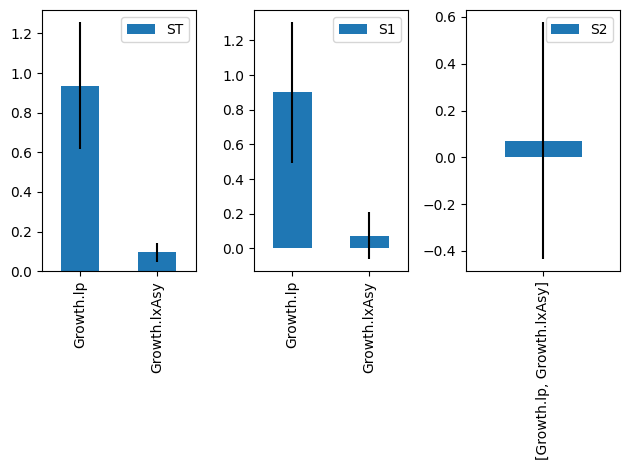

 /home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


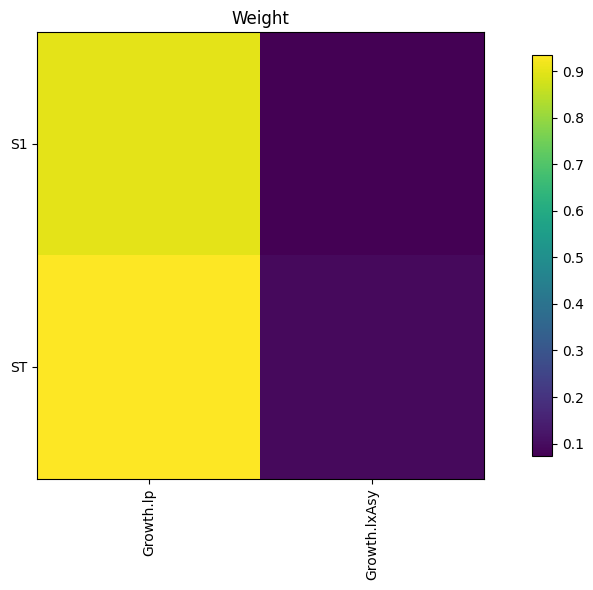

In [5]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = JFruit2()
    props = model.load_properties()
    for k in parameters:
        props[k] = parameters[k]
    model.save_properties(props)

    model.run(
        properties = osp.join("data", "out", f"{model.sim_id}.properties")
    )
    simulated_data = model.results.w.values
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
	observed_data=observed_data.w.values,
	method="sobol",
	n_samples=32,
    n_jobs=8,
	output_labels=["Weight"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=True, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=True,
		num_resamples=200,
		conf_level=0.95,
	),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

# Results

According to the plots above...